真实参数:
g = [0.137 0.195 0.173 0.16  0.116 0.116]
s = [0.106 0.187 0.16  0.171 0.102 0.197]
EM converged at iteration 163

估计参数:
g = [0.123 0.186 0.142 0.16  0.094 0.121]
s = [0.157 0.177 0.1   0.278 0.132 0.263]


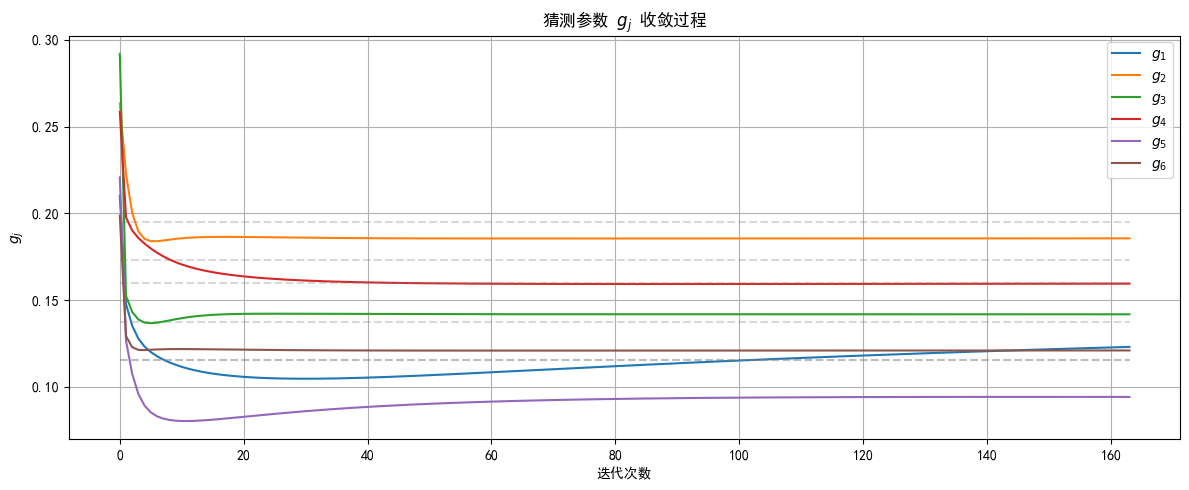

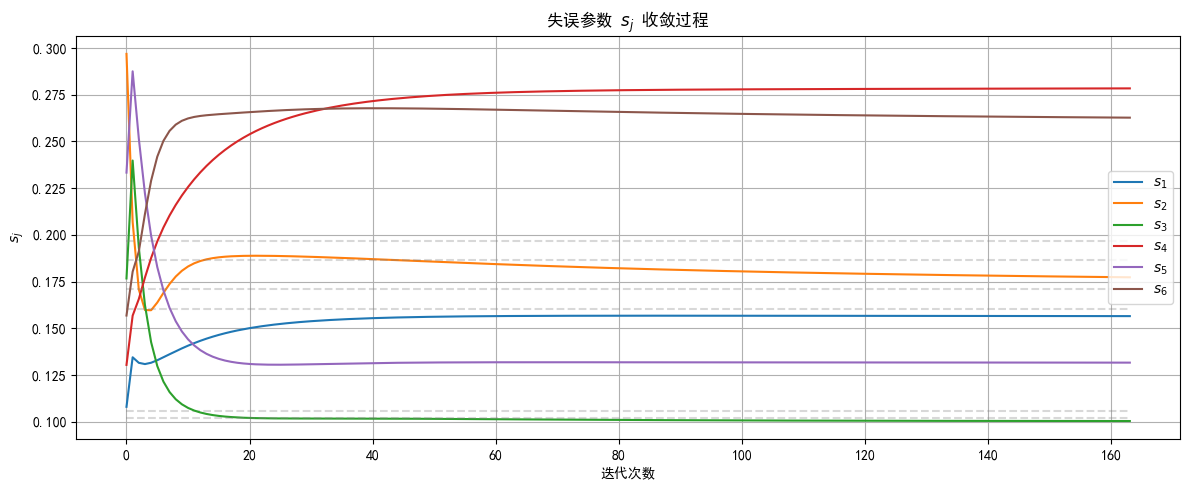

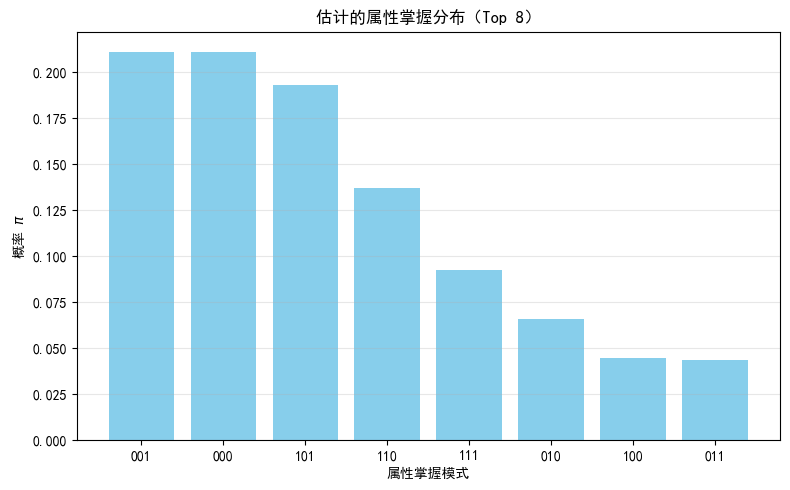

In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

# ==== 模型与数据准备 ====
def generate_all_attributes(K):
    return np.array(list(itertools.product([0, 1], repeat=K)))

def compute_eta(alpha, Q):
    return np.prod(np.power(alpha, Q), axis=1)

def simulate_data(N, Q, attribute_profiles, true_g, true_s, true_pi):
    J = Q.shape[0]
    data = np.zeros((N, J), dtype=int)
    alpha_ids = np.random.choice(len(attribute_profiles), size=N, p=true_pi)
    for i in range(N):
        alpha = attribute_profiles[alpha_ids[i]]
        eta = compute_eta(alpha, Q)
        prob = eta * (1 - true_s) + (1 - eta) * true_g
        data[i] = np.random.binomial(1, prob)
    return data, alpha_ids

# ==== EM算法实现 ====
def em_dina(X, Q, attribute_profiles, max_iter=200, tol=1e-4):
    N, J = X.shape
    L = len(attribute_profiles)
    pi = np.ones(L) / L
    g = np.random.uniform(0.1, 0.3, J)
    s = np.random.uniform(0.1, 0.3, J)

    eta_matrix = np.array([compute_eta(alpha, Q) for alpha in attribute_profiles])  # (L, J)
    history = {"g": [g.copy()], "s": [s.copy()]}

    for it in range(max_iter):
        # E-step
        P_l = np.zeros((N, L))
        for l in range(L):
            prob = eta_matrix[l] * (1 - s) + (1 - eta_matrix[l]) * g
            prob = np.clip(prob, 1e-6, 1 - 1e-6)
            P_l[:, l] = pi[l] * np.prod(prob**X * (1 - prob)**(1 - X), axis=1)
        P_l /= np.sum(P_l, axis=1, keepdims=True)

        # M-step
        pi_new = np.mean(P_l, axis=0)
        g_new = np.zeros(J)
        s_new = np.zeros(J)
        for j in range(J):
            num_s = denom_s = num_g = denom_g = 0
            for l in range(L):
                eta_lj = eta_matrix[l, j]
                weight = P_l[:, l]
                if eta_lj == 1:
                    num_s += np.sum(weight * (1 - X[:, j]))
                    denom_s += np.sum(weight)
                else:
                    num_g += np.sum(weight * X[:, j])
                    denom_g += np.sum(weight)
            s_new[j] = num_s / (denom_s + 1e-10)
            g_new[j] = num_g / (denom_g + 1e-10)

        history["g"].append(g_new.copy())
        history["s"].append(s_new.copy())

        if np.linalg.norm(g_new - g) < tol and np.linalg.norm(s_new - s) < tol:
            print(f"EM converged at iteration {it+1}")
            break

        g, s, pi = g_new, s_new, pi_new

    return g, s, pi, history

# ==== 可视化 ====
def plot_parameter_convergence(history, true_g, true_s):
    g_hist = np.array(history["g"])
    s_hist = np.array(history["s"])
    iterations = range(len(g_hist))

    plt.figure(figsize=(12, 5))
    for j in range(g_hist.shape[1]):
        plt.plot(iterations, g_hist[:, j], label=f"$g_{j+1}$")
        plt.hlines(true_g[j], 0, len(iterations)-1, colors='gray', linestyles='--', alpha=0.3)
    plt.title("猜测参数 $g_j$ 收敛过程")
    plt.xlabel("迭代次数")
    plt.ylabel("$g_j$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    for j in range(s_hist.shape[1]):
        plt.plot(iterations, s_hist[:, j], label=f"$s_{j+1}$")
        plt.hlines(true_s[j], 0, len(iterations)-1, colors='gray', linestyles='--', alpha=0.3)
    plt.title("失误参数 $s_j$ 收敛过程")
    plt.xlabel("迭代次数")
    plt.ylabel("$s_j$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_attribute_distribution(est_pi, attribute_profiles, top_k=8):
    sorted_idx = np.argsort(est_pi)[::-1][:top_k]
    top_profiles = [''.join(map(str, attribute_profiles[i])) for i in sorted_idx]
    top_values = est_pi[sorted_idx]

    plt.figure(figsize=(8, 5))
    plt.bar(top_profiles, top_values, color='skyblue')
    plt.title(f"估计的属性掌握分布（Top {top_k}）")
    plt.xlabel("属性掌握模式")
    plt.ylabel("概率 $\pi$")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==== 主程序入口 ====
def main():
    np.random.seed(42)
    Q = np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 1],
        [1, 0, 1],
        [0, 1, 0],
        [1, 1, 1]
    ])

    J, K = Q.shape
    N = 1000
    attribute_profiles = generate_all_attributes(K)
    L = len(attribute_profiles)

    true_g = np.random.uniform(0.1, 0.2, J)
    true_s = np.random.uniform(0.1, 0.2, J)
    true_pi = np.random.dirichlet([1]*L)

    print("真实参数:")
    print("g =", np.round(true_g, 3))
    print("s =", np.round(true_s, 3))

    X, _ = simulate_data(N, Q, attribute_profiles, true_g, true_s, true_pi)
    est_g, est_s, est_pi, history = em_dina(X, Q, attribute_profiles)

    print("\n估计参数:")
    print("g =", np.round(est_g, 3))
    print("s =", np.round(est_s, 3))

    plot_parameter_convergence(history, true_g, true_s)
    plot_attribute_distribution(est_pi, attribute_profiles)

if __name__ == "__main__":
    main()